In [ ]:
'''
Rough code for correlation analysis of two-photon matched cells data. 
'''

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
from sklearn.metrics import pairwise_distances
import pandas as pd
import scipy.stats as ss
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import kstest
import os
from collections import Counter
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import StandardScaler
from scipy.stats import skew, kurtosis, entropy

z_thresh = 4
filepath = "F:/Two-Photon/Psilocybin Project/Evoked Cohort Mice/compiled_dicts"

In [2]:
# Create an array of all the matched cells that are sound-responsive in both recordings.  Each row is a matched cell pair. 
# INPUTS:  pre- and post- megadicts for a given drug condition. 
#          The specific recording to get matched cells for in the sub-dictionaries of pre- and post.
#          Code is written to be used with the matched cells bandwidth functions. 
# OUTPUTS: (npairs x 2) array containing the matched cell pairs that were responsive in both recordings. 

def get_consistently_responsive_cells(dict_pre,dict_post,sub_dict_pre,sub_dict_post):

    matched_responsive_1 = []
    matched_responsive_2 = []

    # Get the array of matched cell pairs stored under the dictionary's first cell key. 
    matched_cells = dict_post[sub_dict_post][next(iter(dict_post[sub_dict_post]))]['matched_cells']

    # iterate through each cell in the first dict and check if it is a matched cell pair.  Append the matched cells to a list.
    for cell in dict_pre[sub_dict_pre]:
            if cell in matched_cells[:,0] and dict_pre[sub_dict_pre][cell]['active'] == True:
                matched_responsive_1.append(cell)

    # Same operation but with the second dictionary.
    for cell in dict_post[sub_dict_post]:
            if cell in matched_cells[:,1] and dict_post[sub_dict_post][cell]['active'] == True:
                matched_responsive_2.append(cell)

    indices = np.where(np.isin(matched_cells[:, 0], matched_responsive_1))

    # Find the indices where the values in column 0 appear in the first match list.
    indices_col1 = np.isin(matched_cells[:, 0], matched_responsive_1)

    # Find the indices where the values in column 1 appear in the second match list. 
    indices_col2 = np.isin(matched_cells[:, 1], matched_responsive_2)

    # Combine the two conditions using logical AND
    combined_indices = np.logical_and(indices_col1, indices_col2)

    # Extract the rows where both conditions are true
    coactive = matched_cells[combined_indices]

    return coactive

In [3]:
# Dictionary to map filenames to variable names
file_variable_mapping = {
    'saline_pre_dict.pkl': 'saline_pre',
    'saline_post_dict.pkl': 'saline_post',
    'psilo_pre_dict.pkl': 'psilo_pre',
    'psilo_post_dict.pkl': 'psilo_post'
}

# Initialize empty dictionaries
saline_pre = {}
saline_post = {}
psilo_pre = {}
psilo_post = {}

# Iterate through files in megadict folder
for filename in os.listdir(filepath):
    if filename in file_variable_mapping:
        file_path = os.path.join(filepath, filename)
        with open(file_path, 'rb') as file:
            # Load pkl file and assign to respective dictionary variable
            globals()[file_variable_mapping[filename]] = pickle.load(file)

In [4]:
pre_dict_test = saline_pre['saline_1_186']
post_dict_test = saline_post['saline_2_186']



In [5]:
pre_dict_active = {cell: pre_dict_test[cell] for cell in pre_dict_test if pre_dict_test[cell].get('active')}
print(len(pre_dict_active.keys()))

107


In [6]:
coactive = get_consistently_responsive_cells(saline_pre,saline_post,'saline_1_186','saline_2_186')

In [7]:
pre_dict_matched = {cell: pre_dict_test[cell] for cell in coactive[:,0] if cell in pre_dict_test}
post_dict_matched = {cell: post_dict_test[cell] for cell in coactive[:,1] if cell in post_dict_test}

print(len(pre_dict_matched) == len(post_dict_matched))
print(coactive)

True
[[ 15   8]
 [ 28 116]
 [ 30  89]
 [ 34 213]
 [ 54  39]
 [ 55 126]
 [ 57 674]
 [ 58  15]
 [ 67  64]
 [109  50]
 [119 166]
 [121 352]
 [122 196]
 [125  62]
 [126 101]
 [128 343]
 [130 372]
 [131  46]
 [140 349]
 [142  67]
 [152 604]
 [170 150]
 [172  26]
 [175 390]
 [177 183]
 [190 135]
 [197 434]
 [213 368]
 [261 394]
 [298  30]
 [331 102]
 [355 129]
 [414  68]
 [419 229]
 [424 442]
 [426 276]
 [572 457]]


In [8]:
nfreq = list(pre_dict_matched[15]['traces'].keys())
nInt = list(pre_dict_matched[15]['traces'][nfreq[0]].keys())
ntrial = list(pre_dict_matched[15]['traces'][nfreq[0]][nInt[0]].keys())
print(nfreq, nInt, ntrial)

[4364, 5371, 6612, 8140, 10020, 12335, 15184, 18691, 23009, 28324, 34867, 42922] [35, 50, 65, 80] [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


In [9]:
def prepare_matrix(dict):
    matrix = np.array([[[[dict[n]['deconvolved_traces'][i][j][k] for n in dict.keys()] for k in ntrial] for j in nInt] for i in nfreq])
    print("initial matrix shape is", matrix.shape)

    # Average across the trial dimension to produce a mean response
    matrix_avg = matrix.mean(axis=2)
    print(matrix_avg.shape)

    #baseline subtract, so that the mean of the five pre-response frames is removed from the mean of the response.  
    matrix_res = matrix_avg[:,:,:,5:].mean(axis=-1) - matrix_avg[:,:,:,:4].mean(axis=-1)
    print(matrix_res.shape)

    matrix_flatten = (matrix_res).reshape(-1,len(matrix_res[0,0,:]))
    print(matrix_flatten.shape)

    scaler = StandardScaler()
    matrix_scaled = scaler.fit_transform(matrix_flatten)

    pairwise_corr = np.corrcoef(matrix_scaled.T)

    # Compute the pairwise correlations for every cell 
    # pairwise_corr = 1-pairwise_distances(matrix_scaled.T, metric='correlation')
    plt.imshow(pairwise_corr, vmin=-.5, vmax=.5, cmap='bwr')
    print(pairwise_corr.shape)


    return pairwise_corr


In [10]:
def get_all_corr_matrices_matched(dict_pre,dict_post):

    correlation_matrices_pre = {}
    correlation_matrices_post = {}

    for sub_dict_pre, sub_dict_post in zip(dict_pre.keys(),dict_post.keys()):

        # Get the array of consistently responsive matched cell pairs for the pre- and post-conditions. 
        coactive = get_consistently_responsive_cells(dict_pre,dict_post,sub_dict_pre,sub_dict_post)

        pre_dict_matched = {cell: dict_pre[sub_dict_pre][cell] for cell in coactive[:,0] if cell in dict_pre[sub_dict_pre]}
        post_dict_matched = {cell: dict_post[sub_dict_post][cell] for cell in coactive[:,1] if cell in dict_pre[sub_dict_pre]}

        corr_pre = prepare_matrix(pre_dict_matched)

        corr_post = prepare_matrix(post_dict_matched)

        correlation_matrices_pre[sub_dict_pre] = corr_pre

        correlation_matrices_post[sub_dict_post] = corr_post

    return correlation_matrices_pre, correlation_matrices_post

    

initial matrix shape is (12, 4, 10, 37, 15)
(12, 4, 37, 15)
(12, 4, 37)
(48, 37)
(37, 37)
initial matrix shape is (12, 4, 10, 28, 15)
(12, 4, 28, 15)
(12, 4, 28)
(48, 28)
(28, 28)
initial matrix shape is (12, 4, 10, 12, 15)
(12, 4, 12, 15)
(12, 4, 12)
(48, 12)
(12, 12)
initial matrix shape is (12, 4, 10, 7, 15)
(12, 4, 7, 15)
(12, 4, 7)
(48, 7)
(7, 7)
initial matrix shape is (12, 4, 10, 29, 15)
(12, 4, 29, 15)
(12, 4, 29)
(48, 29)
(29, 29)
initial matrix shape is (12, 4, 10, 21, 15)
(12, 4, 21, 15)
(12, 4, 21)
(48, 21)
(21, 21)
initial matrix shape is (12, 4, 10, 52, 15)
(12, 4, 52, 15)
(12, 4, 52)
(48, 52)
(52, 52)
initial matrix shape is (12, 4, 10, 40, 15)
(12, 4, 40, 15)
(12, 4, 40)
(48, 40)
(40, 40)
initial matrix shape is (12, 4, 10, 9, 15)
(12, 4, 9, 15)
(12, 4, 9)
(48, 9)
(9, 9)
initial matrix shape is (12, 4, 10, 8, 15)
(12, 4, 8, 15)
(12, 4, 8)
(48, 8)
(8, 8)
initial matrix shape is (12, 4, 10, 18, 15)
(12, 4, 18, 15)
(12, 4, 18)
(48, 18)
(18, 18)
initial matrix shape is (12,

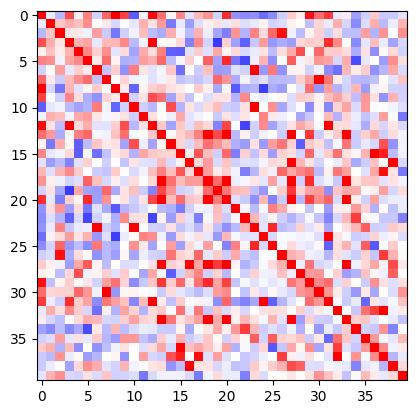

In [15]:
corr_dict_pre, corr_dict_post = get_all_corr_matrices_matched(saline_pre,saline_post)

In [16]:
def get_all_corr_matrices(dict_pre,dict_post):

    correlation_matrices_pre = {}
    correlation_matrices_post = {}

    for sub_dict_pre, sub_dict_post in zip(dict_pre.keys(),dict_post.keys()):

        pre_dict_active = {cell: dict_pre[sub_dict_pre][cell] for cell in dict_pre[sub_dict_pre] if dict_pre[sub_dict_pre][cell].get('active')}
        post_dict_active = {cell: dict_post[sub_dict_post][cell] for cell in dict_post[sub_dict_post] if dict_post[sub_dict_post][cell].get('active')}

        corr_pre = prepare_matrix(pre_dict_active)

        corr_post = prepare_matrix(post_dict_active)

        correlation_matrices_pre[sub_dict_pre] = corr_pre

        correlation_matrices_post[sub_dict_post] = corr_post

    return correlation_matrices_pre, correlation_matrices_post

initial matrix shape is (12, 4, 10, 107, 15)
(12, 4, 107, 15)
(12, 4, 107)
(48, 107)
(107, 107)
initial matrix shape is (12, 4, 10, 109, 15)
(12, 4, 109, 15)
(12, 4, 109)
(48, 109)
(109, 109)
initial matrix shape is (12, 4, 10, 129, 15)
(12, 4, 129, 15)
(12, 4, 129)
(48, 129)
(129, 129)
initial matrix shape is (12, 4, 10, 133, 15)
(12, 4, 133, 15)
(12, 4, 133)
(48, 133)
(133, 133)
initial matrix shape is (12, 4, 10, 114, 15)
(12, 4, 114, 15)
(12, 4, 114)
(48, 114)
(114, 114)
initial matrix shape is (12, 4, 10, 87, 15)
(12, 4, 87, 15)
(12, 4, 87)
(48, 87)
(87, 87)
initial matrix shape is (12, 4, 10, 170, 15)
(12, 4, 170, 15)
(12, 4, 170)
(48, 170)
(170, 170)
initial matrix shape is (12, 4, 10, 128, 15)
(12, 4, 128, 15)
(12, 4, 128)
(48, 128)
(128, 128)
initial matrix shape is (12, 4, 10, 84, 15)
(12, 4, 84, 15)
(12, 4, 84)
(48, 84)
(84, 84)
initial matrix shape is (12, 4, 10, 58, 15)
(12, 4, 58, 15)
(12, 4, 58)
(48, 58)
(58, 58)
initial matrix shape is (12, 4, 10, 265, 15)
(12, 4, 265, 

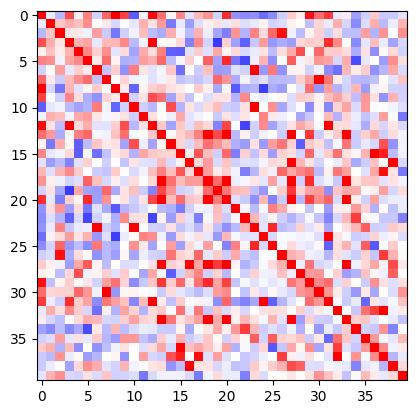

In [17]:
corr_dict_pre, corr_dict_post = get_all_corr_matrices(saline_pre,saline_post)
corr_dict_pre_matched, corr_dict_post_matched = get_all_corr_matrices_matched(saline_pre,saline_post)

Text(0.5, 1.0, 'Post')

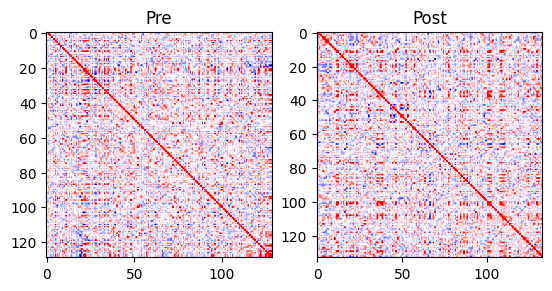

In [18]:
fig, axes = plt.subplots(1,2)

im1 = axes[0].imshow(corr_dict_pre['saline_1_237'], vmin=-.5, vmax=.5, cmap='bwr')
axes[0].set_title("Pre")

im1 = axes[1].imshow(corr_dict_post['saline_2_237'], vmin=-.5, vmax=.5, cmap='bwr')
axes[1].set_title("Post")

In [19]:
test_matrix_1 = corr_dict_pre['saline_1_237']
test_matrix_2 = corr_dict_post['saline_2_237']


In [20]:
print(test_matrix_1)

[[ 1.         -0.23344096  0.09767685 ... -0.201054    0.00167398
   0.00349402]
 [-0.23344096  1.         -0.07722379 ...  0.13672174 -0.03028229
  -0.00835172]
 [ 0.09767685 -0.07722379  1.         ...  0.04110813 -0.18964663
  -0.16171721]
 ...
 [-0.201054    0.13672174  0.04110813 ...  1.          0.1612333
   0.19604426]
 [ 0.00167398 -0.03028229 -0.18964663 ...  0.1612333   1.
   0.96015407]
 [ 0.00349402 -0.00835172 -0.16171721 ...  0.19604426  0.96015407
   1.        ]]


In [21]:
# helper function to replace the diagonal 1 correlation values with NaNs so they don't mess up the mean. 

def fill_diagonal(matrix):
    matrix_copy = matrix.copy()
    np.fill_diagonal(matrix_copy,np.nan)
    return matrix_copy

In [22]:
def add_group_statistics(correlation_dict):
    dict_with_groupstats = {}

    for key, matrix in correlation_dict.items():

        diagonal_nan = fill_diagonal(matrix)

        mean_value = np.nanmean(diagonal_nan)

        median_value = np.nanmedian(diagonal_nan)

        variance_value = np.nanvar(diagonal_nan)

        std_dev = np.nanstd(diagonal_nan)

        skewness = skew(diagonal_nan[~np.isnan(diagonal_nan)].flatten())


        dict_with_groupstats[key] = {
            "matrix": matrix,
            "mean": mean_value,
            "variance": variance_value,
            "std_dev": std_dev,
            "median": median_value,
            "skewness": skewness,
        }
        
    return dict_with_groupstats






initial matrix shape is (12, 4, 10, 107, 15)
(12, 4, 107, 15)
(12, 4, 107)
(48, 107)
(107, 107)
initial matrix shape is (12, 4, 10, 109, 15)
(12, 4, 109, 15)
(12, 4, 109)
(48, 109)
(109, 109)
initial matrix shape is (12, 4, 10, 129, 15)
(12, 4, 129, 15)
(12, 4, 129)
(48, 129)
(129, 129)
initial matrix shape is (12, 4, 10, 133, 15)
(12, 4, 133, 15)
(12, 4, 133)
(48, 133)
(133, 133)
initial matrix shape is (12, 4, 10, 114, 15)
(12, 4, 114, 15)
(12, 4, 114)
(48, 114)
(114, 114)
initial matrix shape is (12, 4, 10, 87, 15)
(12, 4, 87, 15)
(12, 4, 87)
(48, 87)
(87, 87)
initial matrix shape is (12, 4, 10, 170, 15)
(12, 4, 170, 15)
(12, 4, 170)
(48, 170)
(170, 170)
initial matrix shape is (12, 4, 10, 128, 15)
(12, 4, 128, 15)
(12, 4, 128)
(48, 128)
(128, 128)
initial matrix shape is (12, 4, 10, 84, 15)
(12, 4, 84, 15)
(12, 4, 84)
(48, 84)
(84, 84)
initial matrix shape is (12, 4, 10, 58, 15)
(12, 4, 58, 15)
(12, 4, 58)
(48, 58)
(58, 58)
initial matrix shape is (12, 4, 10, 265, 15)
(12, 4, 265, 

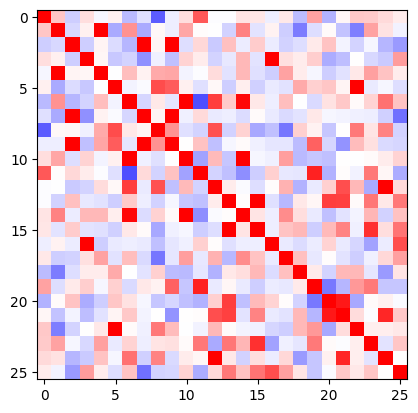

In [23]:
saline_corr_dict_pre, saline_corr_dict_post = get_all_corr_matrices(saline_pre,saline_post)
saline_corr_dict_pre_matched, saline_corr_dict_post_matched = get_all_corr_matrices_matched(saline_pre,saline_post)

psilo_corr_dict_pre, psilo_corr_dict_post = get_all_corr_matrices(psilo_pre,psilo_post)
psilo_corr_dict_pre_matched, psilo_corr_dict_post_matched = get_all_corr_matrices_matched(psilo_pre,psilo_post)

In [24]:
saline_corr_dict_pre_groupstats = add_group_statistics(saline_corr_dict_pre)
saline_corr_dict_post_groupstats = add_group_statistics(saline_corr_dict_post)

psilo_corr_dict_pre_groupstats = add_group_statistics(psilo_corr_dict_pre)
psilo_corr_dict_post_groupstats = add_group_statistics(psilo_corr_dict_post)

In [25]:
# Assuming corr_dict_pre_groupstats is your dictionary with group statistics
saline_mean_values_pre = np.array([stats['mean'] for stats in saline_corr_dict_pre_groupstats.values()])
saline_mean_values_post = np.array([stats['mean'] for stats in saline_corr_dict_post_groupstats.values()])

# Print the resulting array
print(saline_mean_values_pre)
print(saline_mean_values_post)

[0.0201343  0.02069041 0.0586262  0.05589134 0.01857338 0.02483378
 0.04466657 0.02122182]
[0.02344063 0.02414176 0.02736984 0.0792861  0.02628718 0.02569376
 0.03235462 0.02306872]


In [26]:
# Assuming corr_dict_pre_groupstats is your dictionary with group statistics
psilo_mean_values_pre = np.array([stats['mean'] for stats in psilo_corr_dict_pre_groupstats.values()])
psilo_mean_values_post = np.array([stats['mean'] for stats in psilo_corr_dict_post_groupstats.values()])

# Print the resulting array
print(psilo_mean_values_pre)
print(psilo_mean_values_post)

[0.01104099 0.01451898 0.03504337 0.03304048 0.01502216 0.01348871
 0.0346455  0.02624266]
[0.02898528 0.00261737 0.02208492 0.02825068 0.02111213 0.00896566
 0.03733772 0.02095922]


In [118]:
from scipy.stats import mannwhitneyu

# Assuming pre_means and post_means are your arrays of means
stat, p_value = mannwhitneyu(saline_mean_values_pre, saline_mean_values_post, alternative='two-sided')
print(stat,p_value)

24.0 0.4418026418026417


In [119]:
# Assuming pre_means and post_means are your arrays of means
stat, p_value = mannwhitneyu(psilo_mean_values_pre, psilo_mean_values_post, alternative='two-sided')
print(stat,p_value)

34.0 0.8784770784770783


C:\Users\Conor\AppData\Local\Temp\ipykernel_3228\3505031748.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Condition', y='Mean Value', data=df, palette='Set2', width=0.5, boxprops={'facecolor':'lightgrey'})


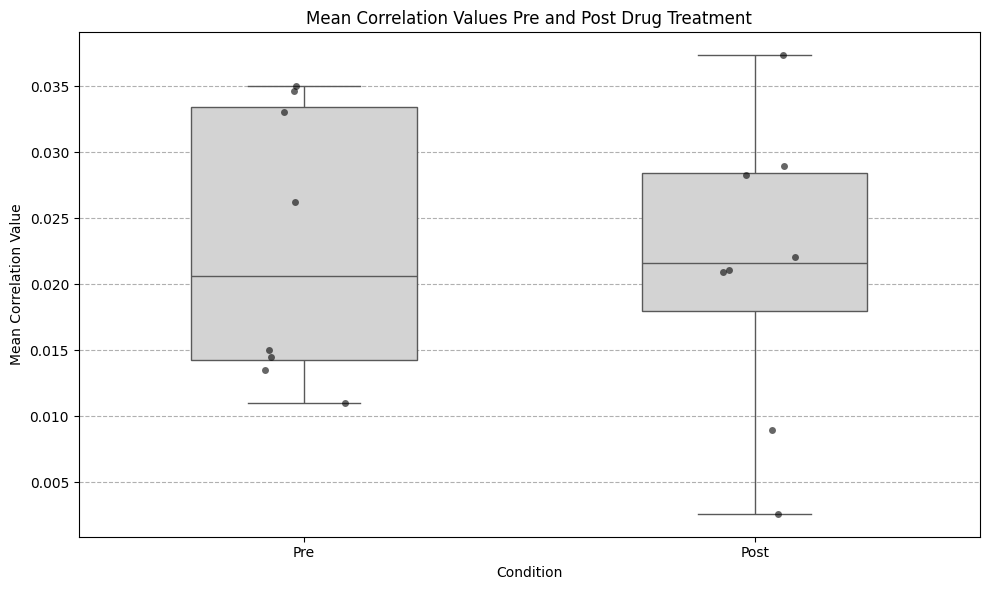

In [120]:
# Example data (replace with your actual mean arrays)
mean_pre = psilo_mean_values_pre  # Pre-drug mean values
mean_post = psilo_mean_values_post  # Post-drug mean values

# Create DataFrame for easier plotting with seaborn
df_pre = pd.DataFrame({'Condition': ['Pre'] * len(mean_pre), 'Mean Value': mean_pre})
df_post = pd.DataFrame({'Condition': ['Post'] * len(mean_post), 'Mean Value': mean_post})

# Combine the DataFrames
df = pd.concat([df_pre, df_post], ignore_index=True)

# Set up the matplotlib figure
plt.figure(figsize=(10, 6))

# Create a boxplot with stripplot overlay
sns.boxplot(x='Condition', y='Mean Value', data=df, palette='Set2', width=0.5, boxprops={'facecolor':'lightgrey'})
sns.stripplot(x='Condition', y='Mean Value', data=df, color='black', alpha=0.6, jitter=True)

# Adding titles and labels
plt.title('Mean Correlation Values Pre and Post Drug Treatment')
plt.ylabel('Mean Correlation Value')
plt.grid(axis='y', linestyle='--')

# Show the plot
plt.tight_layout()
plt.show()

C:\Users\Conor\AppData\Local\Temp\ipykernel_3228\2707971956.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Condition', y='Mean Value', data=df, palette='Set2', width=0.5, boxprops={'facecolor':'lightgrey'})


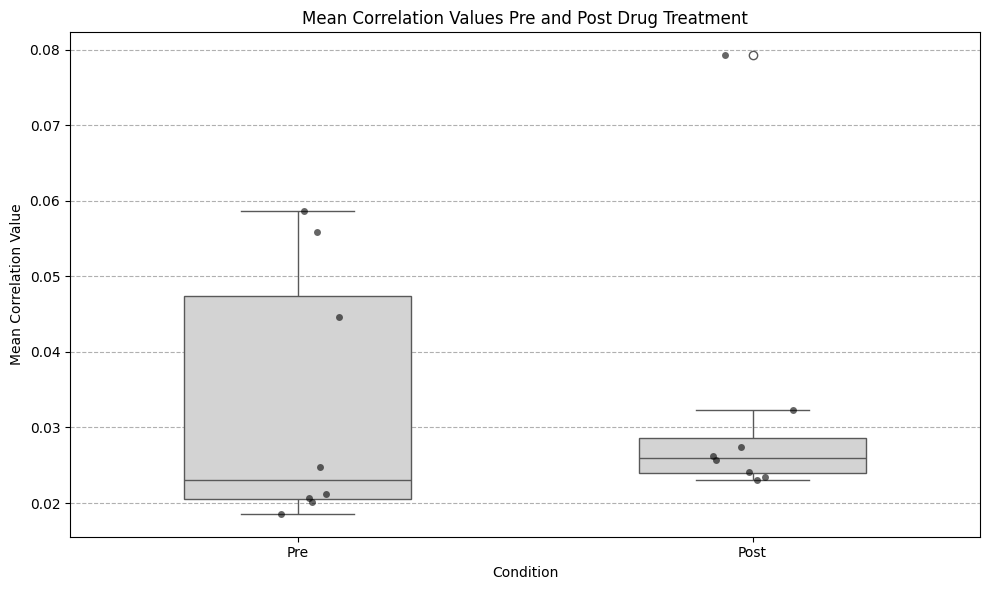

In [121]:
# Example data (replace with your actual mean arrays)
mean_pre = saline_mean_values_pre  # Pre-drug mean values
mean_post = saline_mean_values_post  # Post-drug mean values

# Create DataFrame for easier plotting with seaborn
df_pre = pd.DataFrame({'Condition': ['Pre'] * len(mean_pre), 'Mean Value': mean_pre})
df_post = pd.DataFrame({'Condition': ['Post'] * len(mean_post), 'Mean Value': mean_post})

# Combine the DataFrames
df = pd.concat([df_pre, df_post], ignore_index=True)

# Set up the matplotlib figure
plt.figure(figsize=(10, 6))

# Create a boxplot with stripplot overlay
sns.boxplot(x='Condition', y='Mean Value', data=df, palette='Set2', width=0.5, boxprops={'facecolor':'lightgrey'})
sns.stripplot(x='Condition', y='Mean Value', data=df, color='black', alpha=0.6, jitter=True)

# Adding titles and labels
plt.title('Mean Correlation Values Pre and Post Drug Treatment')
plt.ylabel('Mean Correlation Value')
plt.grid(axis='y', linestyle='--')

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
'''

SIGNAL/NOISE CORRELATION
'''

107
initial matrix shape is (12, 4, 10, 107, 15)
shape after baseline correct (12, 4, 10, 107)
(480, 107)
(107, 107)


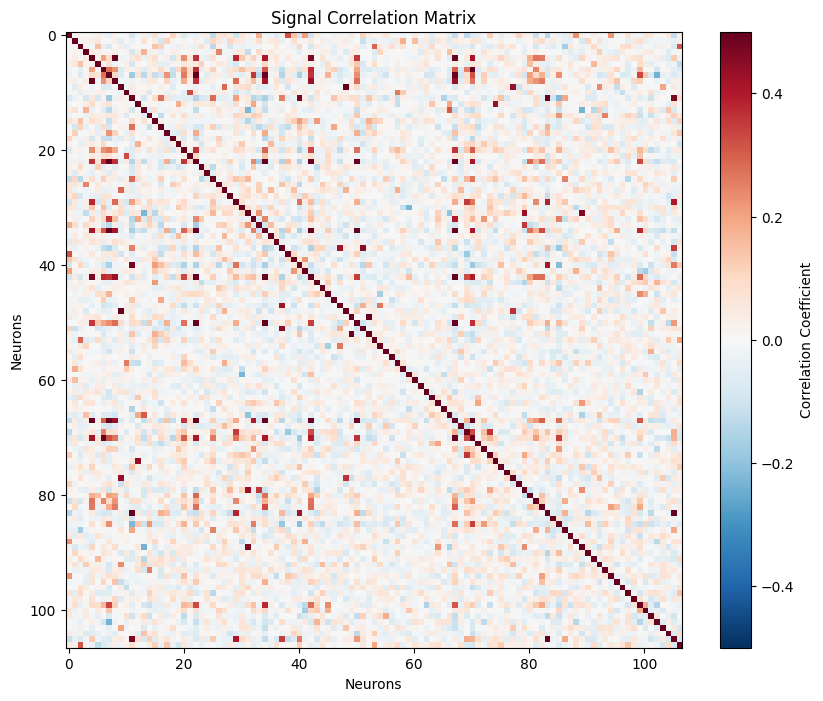

In [41]:
pre_dict_test = saline_pre['saline_1_186']
pre_dict_active = {cell: pre_dict_test[cell] for cell in pre_dict_test if pre_dict_test[cell].get('active')}
print(len(pre_dict_active.keys()))

matrix = np.array([[[[pre_dict_active[n]['deconvolved_traces'][i][j][k] for n in pre_dict_active.keys()] for k in ntrial] for j in nInt] for i in nfreq])
print("initial matrix shape is", matrix.shape)

#baseline subtract, so that the mean of the five pre-response frames is removed from the mean of the response.  
matrix_res = matrix[:,:,:,:,4:].mean(axis=-1) - matrix[:,:,:,:,:4].mean(axis=-1)
print("shape after baseline correct", matrix_res.shape)

matrix_flatten = (matrix_res).reshape(-1,len(matrix_res[0,0,0,:]))
print(matrix_flatten.shape)

scaler = StandardScaler()
matrix_scaled = scaler.fit_transform(matrix_flatten)

signal_correlations = np.corrcoef(matrix_flatten, rowvar=False)  # Shape: (438, 438)
print(signal_correlations.shape)

plt.figure(figsize=(10, 8))
plt.imshow(signal_correlations, cmap='RdBu_r', vmin=-0.5, vmax=0.5)
plt.colorbar(label='Correlation Coefficient')
plt.title('Signal Correlation Matrix')
plt.xlabel('Neurons')
plt.ylabel('Neurons')
plt.show()


107
initial matrix shape is (12, 4, 10, 107, 15)
shape after baseline correct (12, 4, 10, 107)
(12, 4, 10, 107)


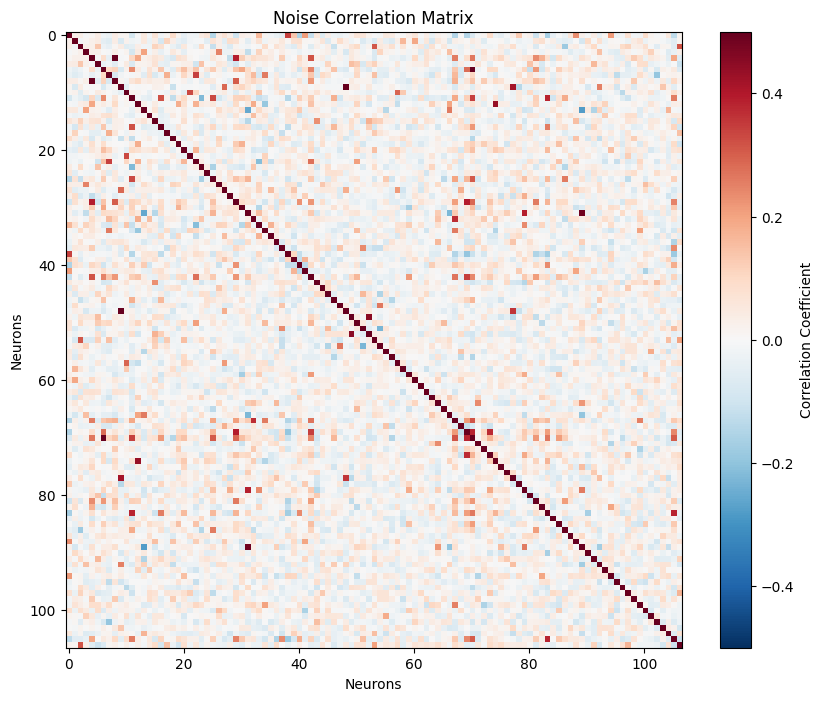

In [48]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

pre_dict_test = saline_pre['saline_1_186']
pre_dict_active = {cell: pre_dict_test[cell] for cell in pre_dict_test if pre_dict_test[cell].get('active')}
print(len(pre_dict_active.keys()))

matrix = np.array([[[[pre_dict_active[n]['deconvolved_traces'][i][j][k] for n in pre_dict_active.keys()] for k in ntrial] for j in nInt] for i in nfreq])
print("initial matrix shape is", matrix.shape)

#baseline subtract, so that the mean of the five pre-response frames is removed from the mean of the response.  
matrix_res = matrix[:,:,:,:,4:].mean(axis=-1) - matrix[:,:,:,:,:4].mean(axis=-1)
print("shape after baseline correct", matrix_res.shape)

# Step 2: Calculate trial-to-trial deviations for each frequency-intensity condition
trial_deviations = matrix_res - np.mean(matrix_res, axis=2, keepdims=True)  # Shape: (12, 4, 10, 438)
print(trial_deviations.shape)

# Step 3: Flatten frequency and intensity into a single dimension (48 combinations)
flattened_trial_deviations = trial_deviations.reshape(12 * 4, 10, 107)  # Shape: (48, 10, 438)

# Step 4: Compute noise correlations (correlations of trial-to-trial deviations across neurons)
# First, reshape to merge trials and conditions: (480, 438), where 480 = 48*10 (flattened trials)
reshaped_trial_deviations = flattened_trial_deviations.reshape(48 * 10, 107)  # Shape: (480, 438)
noise_correlations = np.corrcoef(reshaped_trial_deviations, rowvar=False)  # Shape: (438, 438)

plt.figure(figsize=(10, 8))
plt.imshow(noise_correlations, cmap='RdBu_r', vmin=-0.5, vmax=0.5)
plt.colorbar(label='Correlation Coefficient')
plt.title('Noise Correlation Matrix')
plt.xlabel('Neurons')
plt.ylabel('Neurons')
plt.show()


In [ ]:
"""
Needs to be scaled by distance
Calculate euclidean distance
Convert it to pixels - need the correct conversion.



"""